In [1]:
from math import log10
from pathlib import Path
import pandas as pd
from fastsolv import fastsolv
from thermo.chemical import Chemical
import numpy as np
import itertools
import polars as pl
import matplotlib
import matplotlib.pyplot as plt
import os
from rdkit import Chem
from rdkit.Chem import Draw
from fastsolv_analysis.util import query_fastsolv


matplotlib.rcParams.update({'font.style': 'normal'})
matplotlib.rcParams.update({'font.sans-serif': 'Segoe UI'})
matplotlib.rcParams.update({'font.size': 26})

C:\Users\ChemeGrad2021\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\ChemeGrad2021\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.3.1, which is newer than your current Lightning version: v2.2.4


In [2]:
# convert the mol fraction to concentration
def _fraction_to_molarity(row):
    name = row["solvent_name"]
    if name == "THF":
        name = "tetrahydrofuran"
    elif name == "n-heptane":
        name = "heptane"
    elif name == "DMS":
        name = "methylthiomethane"
    elif name == "2-ethyl-n-hexanol":
        name = "2-Ethyl hexanol"
    elif name == "3,6-dioxa-1-decanol":
        name = "butoxyethoxyethanol"
    elif name == "DEF":
        name = "diethylformamide"
    try:
        m = Chemical(name, T=row["temperature"])
    except ValueError:
        print(f"Could not find chemical name {name}.")
        return pd.NA
    try:
        return log10(row["mol_fraction"] / (m.MW / m.rho))
    except TypeError as e:
        print(name, "could not be estimated.")
        print(str(e))
        return pd.NA
    
def compute_rmse(exp_temp, exp_logS, model_temp, model_logS):
    matched_values = []
    
    for t, logS in zip(exp_temp, exp_logS):
        # Find model temperature closest to experiment within ±0.5 K
        valid_indices = np.where(np.abs(model_temp - t) <= 0.5)[0]
        if valid_indices.size > 0:
            closest_idx = valid_indices[0]  # Take the first valid match
            matched_values.append((logS, model_logS[closest_idx]))

    if matched_values:
        exp_matched, pred_matched = zip(*matched_values)
        rmse = np.sqrt(np.mean((np.array(exp_matched) - np.array(pred_matched))**2))
        return rmse
    else:
        return None  # No matching data points

In [3]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\data")
anthracenes: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "anthracenes.csv"))

In [4]:
anthracenes.insert(1, "logS", anthracenes[["temperature", "solvent_name", "mol_fraction"]].apply(_fraction_to_molarity, axis=1))
print(len(anthracenes), "<-- size without un-estimable solvents")

# drop multiple-fragment species
def _is_one_mol(row):
    if "." in row["solute_smiles"]:
        return False
    return True


anthracenes = anthracenes[anthracenes[["solute_smiles"]].apply(_is_one_mol, axis=1)]
print(len(anthracenes), "<-- count after dropping non-single molecule solutes")
anthracenes = anthracenes.reset_index()

30 <-- size without un-estimable solvents
30 <-- count after dropping non-single molecule solutes


In [5]:
anthracenes.to_csv(path_or_buf=os.path.join(_src_dir, "anthracenes_logS.csv"))

In [6]:
anthracenes = pl.from_pandas(anthracenes)
anthracene_acetonitrile = anthracenes.filter(
    (pl.col("solute_name") == "anthracene") & (pl.col("solvent_name") == "acetonitrile")
)

anthracene_acetonitrile = anthracenes.filter((pl.col('solute_name') == 'anthracene') & (pl.col('solvent_name') == 'acetonitrile'))
anthracene_ipa = anthracenes.filter((pl.col("solute_name") == 'anthracene') & (pl.col("solvent_name") == 'isopropyl alcohol'))
anthracene_mek = anthracenes.filter((pl.col("solute_name") == 'anthracene') & (pl.col("solvent_name") == 'methyl ethyl ketone'))

anthraquinone_acetonitrile = anthracenes.filter((pl.col("solute_name") == 'anthraquinone') & (pl.col("solvent_name") == 'acetonitrile'))
anthraquinone_ipa = anthracenes.filter((pl.col("solute_name") == 'anthraquinone') & (pl.col("solvent_name") == 'isopropyl alcohol'))
anthraquinone_mek = anthracenes.filter((pl.col("solute_name") == 'anthraquinone') & (pl.col("solvent_name") == 'methyl ethyl ketone'))

In [ ]:
solvent_list = ["CCC(=O)C", "CC#N", "CC(C)O"]
solute_list = ["C1=CC=C2C=C3C=CC=CC3=CC2=C1", "C1=CC=C2C(=C1)C(=O)C3=CC=CC=C3C2=O"]

anthracenes_predictions = []

for solute, solvent in itertools.product(solute_list, solvent_list):
    data = dict(
        solvent_smiles=[solvent]*30,
        solute_smiles= [solute]*30,
        temperature=np.linspace(295, 325, 30),
    )
    df = pd.DataFrame(data)
    predictions = fastsolv(df)
    anthracenes_predictions.append(predictions) 



100%|██████████| 2/2 [00:03<00:00,  1.50s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.84it/s]



100%|██████████| 2/2 [00:02<00:00,  1.43s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.22it/s]



100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.43it/s]



100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Predicting: |          | 0/? [06:25<?, ?it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.74it/s]


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.76it/s]


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.18it/s]


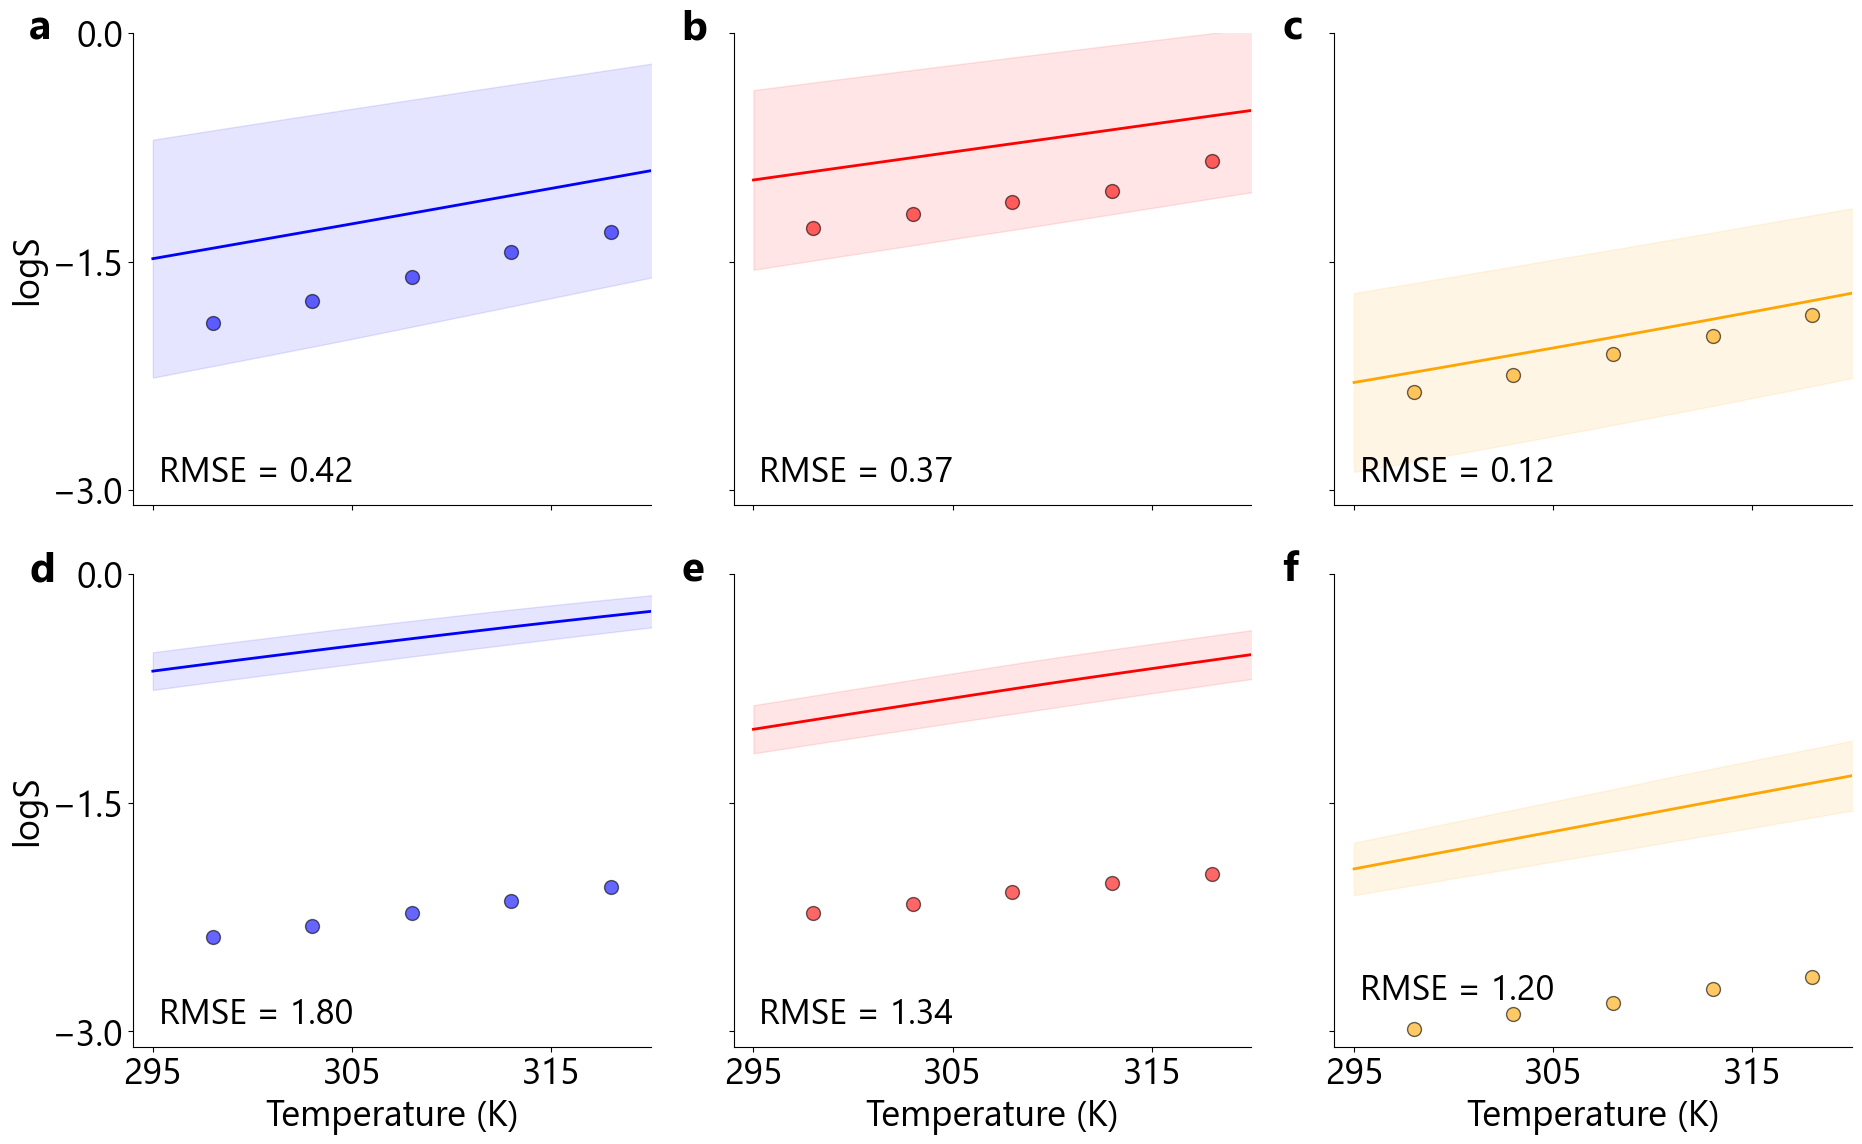

In [163]:
fig = plt.figure(figsize=(6.4*3, 4.8*2.5))  # Adjust the figure size 

ax1 = plt.subplot2grid(shape=(2, 3), loc=(0, 0), colspan=1)

ax1.plot(anthracene_acetonitrile['temperature'], anthracene_acetonitrile['logS'], color='b', marker = 'o', markersize = 10, linestyle = 'none', markeredgecolor = 'black', alpha = 0.6, label='acetonitrile')
ax1.plot(data['temperature'], anthracenes_predictions[1]['predicted_logS'].values, color='b', marker = 'none', linewidth = 2, linestyle = '-')
ax1.fill_between(data['temperature'], np.subtract(anthracenes_predictions[1]['predicted_logS'].values, anthracenes_predictions[1]['predicted_logS_stdev'].values), np.add(anthracenes_predictions[1]['predicted_logS'].values, anthracenes_predictions[1]['predicted_logS_stdev'].values) , alpha = 0.1, color = 'b')

ax1.set_ylabel("logS")
ax1.set_xlim([294,320])
ax1.set_xticks([295, 305, 315])
ax1.set_ylim([-3.1,0])
ax1.set_yticks([-3, -1.5,0])
ax1.set_xticklabels([])
#ax1.legend(prop={'size': 20}, loc = 'lower center', frameon = True) 
ax1.spines[['right', 'top']].set_visible(False)

ax2 = plt.subplot2grid(shape=(2, 3), loc=(0, 1), colspan=1)
ax2.plot(anthracene_mek['temperature'], anthracene_mek['logS'], color='r', marker = 'o', markersize = 10, linestyle = 'none', markeredgecolor = 'black', alpha = 0.6, label='methyl ethyl ketone')
ax2.plot(data['temperature'], anthracenes_predictions[0]['predicted_logS'].values, color='red', marker = 'none', linewidth = 2, linestyle = '-')
ax2.fill_between(data['temperature'], np.subtract(anthracenes_predictions[0]['predicted_logS'].values, anthracenes_predictions[0]['predicted_logS_stdev'].values), np.add(anthracenes_predictions[0]['predicted_logS'].values, anthracenes_predictions[0]['predicted_logS_stdev'].values) , alpha = 0.1, color = 'red')

ax2.set_xlim([294,320])
ax2.set_xticks([295, 305, 315])
ax2.set_ylim([-3.1,0])
ax2.set_yticks([-3, -1.5,0])
ax2.set_yticklabels([])
ax2.set_xticklabels([])
#ax2.legend(prop={'size': 20}, loc = 'lower center', frameon = True) 
ax2.spines[['right', 'top']].set_visible(False)


ax3 = plt.subplot2grid(shape=(2, 3), loc=(0, 2), colspan=1)
ax3.plot(anthracene_ipa['temperature'], anthracene_ipa['logS'], color='orange', marker = 'o', markersize = 10, linestyle = 'none', markeredgecolor = 'black', alpha = 0.6, label='isopropyl alcohol')
ax3.plot(data['temperature'], anthracenes_predictions[2]['predicted_logS'].values, color='orange', marker = 'none', linewidth = 2, linestyle = '-')
ax3.fill_between(data['temperature'], np.subtract(anthracenes_predictions[2]['predicted_logS'].values, anthracenes_predictions[2]['predicted_logS_stdev'].values), np.add(anthracenes_predictions[2]['predicted_logS'].values, anthracenes_predictions[2]['predicted_logS_stdev'].values) , alpha = 0.1, color = 'orange')

ax3.set_xlim([294,320])
ax3.set_xticks([295, 305, 315])
ax3.set_ylim([-3.1,0])
ax3.set_yticks([-3, -1.5,0])
ax3.set_yticklabels([])
ax3.set_xticklabels([])
#ax3.legend(prop={'size': 20}, loc = 'upper center', frameon = True) 
ax3.spines[['right', 'top']].set_visible(False)

ax4 = plt.subplot2grid(shape=(2, 3), loc=(1, 0), colspan=1)

ax4.plot(anthraquinone_acetonitrile['temperature'], anthraquinone_acetonitrile['logS'], color='b', marker = 'o', markersize = 10, linestyle = 'none', markeredgecolor = 'black', alpha = 0.6, label='acetonitrile')
ax4.plot(data['temperature'], anthracenes_predictions[3]['predicted_logS'].values, color='b', marker = 'none', linewidth = 2, linestyle = '-')
ax4.fill_between(data['temperature'], np.subtract(anthracenes_predictions[3]['predicted_logS'].values, anthracenes_predictions[3]['predicted_logS_stdev'].values), np.add(anthracenes_predictions[3]['predicted_logS'].values, anthracenes_predictions[3]['predicted_logS_stdev'].values) , alpha = 0.1, color = 'b')

ax4.set_xlabel("Temperature (K)")
ax4.set_ylabel("logS")
ax4.set_xlim([294,320])
ax4.set_xticks([295, 305, 315])
ax4.set_ylim([-3.1,0])
ax4.set_yticks([-3, -1.5,0])
#ax4.legend(prop={'size': 20}, loc = 'lower center', frameon = True) 
ax4.spines[['right', 'top']].set_visible(False)

ax5 = plt.subplot2grid(shape=(2, 3), loc=(1, 1), colspan=1)

ax5.plot(anthraquinone_mek['temperature'], anthraquinone_mek['logS'], color='r', marker = 'o', markersize = 10, linestyle = 'none', markeredgecolor = 'black', alpha = 0.6, label='methyl ethyl ketone')
ax5.plot(data['temperature'], anthracenes_predictions[4]['predicted_logS'].values, color='r', marker = 'none', linewidth = 2, linestyle = '-')
ax5.fill_between(data['temperature'], np.subtract(anthracenes_predictions[4]['predicted_logS'].values, anthracenes_predictions[4]['predicted_logS_stdev'].values), np.add(anthracenes_predictions[4]['predicted_logS'].values, anthracenes_predictions[4]['predicted_logS_stdev'].values) , alpha = 0.1, color = 'r')

ax5.set_xlabel("Temperature (K)")
ax5.set_xlim([294,320])
ax5.set_xticks([295, 305, 315])
ax5.set_ylim([-3.1,0])
ax5.set_yticks([-3, -1.5,0])
#ax5.legend(prop={'size': 20}, loc = 'lower center', frameon = True) 
ax5.spines[['right', 'top']].set_visible(False)
ax5.set_yticklabels([])

ax6 = plt.subplot2grid(shape=(2, 3), loc=(1, 2), colspan=1)

ax6.plot(anthraquinone_ipa['temperature'], anthraquinone_ipa['logS'], color='orange', marker = 'o', markersize = 10, linestyle = 'none', markeredgecolor = 'black', alpha = 0.6, label='isopropyl alcohol')
ax6.plot(data['temperature'], anthracenes_predictions[5]['predicted_logS'].values, color='orange', marker = 'none', linewidth = 2, linestyle = '-')
ax6.fill_between(data['temperature'], np.subtract(anthracenes_predictions[5]['predicted_logS'].values, anthracenes_predictions[5]['predicted_logS_stdev'].values), np.add(anthracenes_predictions[5]['predicted_logS'].values, anthracenes_predictions[5]['predicted_logS_stdev'].values) , alpha = 0.1, color = 'orange')

ax6.set_xlabel("Temperature (K)")
ax6.set_xlim([294,320])
ax6.set_xticks([295, 305, 315])
ax6.set_ylim([-3.1,0])
ax6.set_yticks([-3, -1.5,0])
#ax6.legend(prop={'size': 20}, loc = 'upper center', frameon = True) 
ax6.spines[['right', 'top']].set_visible(False)
ax6.set_yticklabels([])
labels = ['a', 'b', 'c', 'd', 'e', 'f']
for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6]):
    if ax in [ax2, ax3, ax5, ax6]:
        ax.text(-0.1, 1.05, labels[i], transform=ax.transAxes, fontsize=30, fontweight='bold', va='top', ha='left')
    else:
       ax.text(-0.2, 1.05, labels[i], transform=ax.transAxes, fontsize=30, fontweight='bold', va='top', ha='left')

datasets = [
    (anthracene_acetonitrile, anthracenes_predictions[1]),
    (anthracene_mek, anthracenes_predictions[0]),
    (anthracene_ipa, anthracenes_predictions[2]),
    (anthraquinone_acetonitrile, anthracenes_predictions[3]),
    (anthraquinone_mek, anthracenes_predictions[4]),
    (anthraquinone_ipa, anthracenes_predictions[5])
]

for i, (ax, (exp_data, model_pred)) in enumerate(zip([ax1, ax2, ax3, ax4, ax5, ax6], datasets)):
    # Compute RMSE
    rmse = compute_rmse(
        exp_data['temperature'], exp_data['logS'],
        data['temperature'], model_pred['predicted_logS'].values
    )
    
    if rmse is not None and ax!= ax6:
        ax.text(0.05, 0.05, f'RMSE = {rmse:.2f}', transform=ax.transAxes, fontsize=25, color='black')
    else: 
        ax.text(0.05, 0.1, f'RMSE = {rmse:.2f}', transform=ax.transAxes, fontsize=25, color='black')

plt.tight_layout()


Let's draw the solutes and solvents so we can add them to the Figure outside this notebook

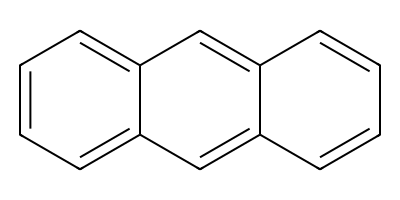

In [39]:
img = Draw.MolToImage(Chem.MolFromSmiles(solute_list[0]), size=(400, 200))
img

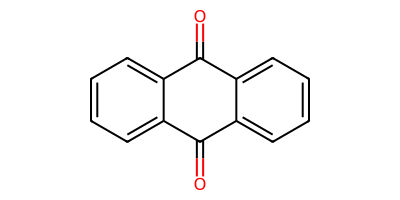

In [40]:
img = Draw.MolToImage(Chem.MolFromSmiles(solute_list[1]), size=(400, 200))
img

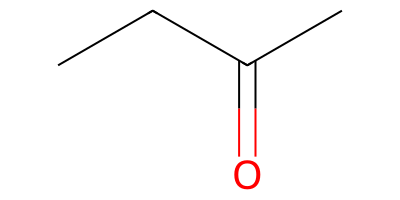

In [41]:
img = Draw.MolToImage(Chem.MolFromSmiles(solvent_list[0]), size=(400, 200))
img

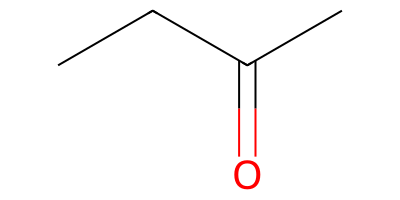

In [42]:
img = Draw.MolToImage(Chem.MolFromSmiles(solvent_list[0]), size=(400, 200))
img

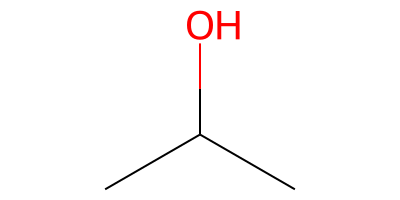

In [43]:
img = Draw.MolToImage(Chem.MolFromSmiles(solvent_list[2]), size=(400, 200))
img

Upon inspection, we also found that SolProp contains some solubility data on anthracene and anthraquinone derivatives, all at room temperature. We will now load those and look at model predictions

In [9]:
solprop = pl.read_csv(Path(r"C:\Users\ChemeGrad2021\Documents\highsol\data\SolProp_v1.2\Data\CombiSolu-Exp.csv"), columns=["solute_smiles", "solvent_smiles", "experimental_logS [mol/L]", "temperature", "source"]).to_pandas()
solprop = solprop.groupby(["solute_smiles", "solvent_smiles"])[["experimental_logS [mol/L]", "temperature", "source",]].aggregate(list)

In [ ]:
# Run fastsolv on the given DataFrames
anthracene_solprop = query_fastsolv(solprop, 
                                    "C1=CC=C2C=C3C=CC=CC3=CC2=C1", 298.15, 298.15, num_temp=1)
ethylanthraquinone_solprop = query_fastsolv(solprop, 
                                            "CCC1=CC2=C(C=C1)C(=O)C3=CC=CC=C3C2=O", 298.15, 298.15, num_temp=1)
chloroanthraquinone_solprop = query_fastsolv(solprop, 
                                             "C1=CC=C2C(=C1)C(=O)C3=C(C2=O)C(=CC=C3)Cl", 298.15, 298.15, num_temp=1)

# Combine the DataFrames
combined_df = pd.concat([anthracene_solprop, ethylanthraquinone_solprop, chloroanthraquinone_solprop])

results = fastsolv(combined_df)

100%|██████████| 56/56 [00:06<00:00,  9.22it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.00it/s]


Now, we add the corresponding experimental solubility values back into the dataframe to compute the RMSE for these solutions.

In [37]:
exp_logS_values = []
for index, row in results.iterrows():
    solute_smiles, solvent_smiles, temperature = index
    try:
        exp_logS = solprop.loc[(solute_smiles, solvent_smiles), "experimental_logS [mol/L]"]
        exp_temp = solprop.loc[(solute_smiles, solvent_smiles), "temperature"]
        
        # Find the experimental logS value corresponding to the same temperature
        exp_logS_at_temp = exp_logS[exp_temp.index(temperature)]
        exp_logS_values.append(exp_logS_at_temp)

    except KeyError:
        print(f"No matching experimental data for {solute_smiles}, {solvent_smiles} at {temperature} K")
        exp_logS_values.append(pd.NA)
    except ValueError:
        print(f"Temperature {temperature} K not found in experimental data for {solute_smiles}, {solvent_smiles}")
        exp_logS_values.append(pd.NA)

# Add the exp_logS_at_temp values as a new column in the results DataFrame
results['logS'] = exp_logS_values

In [54]:
rmse = np.sqrt(np.mean((results['logS'] - results['predicted_logS'])**2))
print(f"Overall RMSE: {rmse:.2f}", "N = " + str(len(results)))
unique_solvents = results.index.get_level_values('solvent_smiles').unique()
print(f"Number of unique solvents: {len(unique_solvents)}")

Overall RMSE: 0.52 N = 85
Number of unique solvents: 53


In [67]:
results

predicted_logS  \
solute_smiles                            solvent_smiles temperature                   
C1=CC=C2C=C3C=CC=CC3=CC2=C1              CC1=CC=CC=C1   298.15            -0.585478   
                                         CCC1=CC=CC=C1  298.15            -0.636463   
                                         CCOC(=O)OCC    298.15            -0.224787   
                                         COC(=O)OC      298.15            -0.798426   
CCC1=CC2=C(C=C1)C(=O)C3=CC=CC=C3C2=O     C1CCC(CC1)Cl   298.15            -0.848594   
...                                                                             ...   
C1=CC=C2C(=C1)C(=O)C3=C(C2=O)C(=CC=C3)Cl CCO            298.15            -1.563569   
                                         CCOC(=O)C      298.15            -0.966600   
                                         CCOC(=O)OCC    298.15            -0.474909   
                                         CCOCC          298.15            -1.217263   
                                         CO             298.15            -1.651322   

                                                                     predicted_logS_stdev  \
solute_smiles                            solvent_smiles temperature                         
C1=CC=C2C=C3C=CC=CC3=CC2=C1              CC1=CC=CC=C1   298.15                   0.534447   
                                         CCC1=CC=CC=C1  298.15                   0.447266   
                                         CCOC(=O)OCC    298.15                   0.363521   
                                         COC(=O)OC      298.15                   0.374457   
CCC1=CC2=C(C=C1)C(=O)C3=CC=CC=C3C2=O     C1CCC(CC1)Cl   298.15                   0.225938   
...                                                                                   ...   
C1=CC=C2C(=C1)C(=O)C3=C(C2=O)C(=CC=C3)Cl CCO            298.15                   0.283487   
                                         CCOC(=O)C      298.15                   0.095678   
                                         CCOC(=O)OCC    298.15                   0.193324   
                                         CCOCC          298.15                   0.238091   
                                         CO             298.15                   0.353926   

                                                                     exp_logS_at_temp  \
solute_smiles                            solvent_smiles temperature                     
C1=CC=C2C=C3C=CC=CC3=CC2=C1              CC1=CC=CC=C1   298.15              -1.155846   
                                         CCC1=CC=CC=C1  298.15              -1.236723   
                                         CCOC(=O)OCC    298.15              -1.342740   
                                         COC(=O)OC      298.15              -1.426855   
CCC1=CC2=C(C=C1)C(=O)C3=CC=CC=C3C2=O     C1CCC(CC1)Cl   298.15              -0.506412   
...                                                                               ...   
C1=CC=C2C(=C1)C(=O)C3=C(C2=O)C(=CC=C3)Cl CCO            298.15              -2.207079   
                                         CCOC(=O)C      298.15              -1.149202   
                                         CCOC(=O)OCC    298.15              -1.190429   
                                         CCOCC          298.15              -1.711204   
                                         CO             298.15              -2.231929   

                                                                         logS  
solute_smiles                            solvent_smiles temperature            
C1=CC=C2C=C3C=CC=CC3=CC2=C1              CC1=CC=CC=C1   298.15      -1.155846  
                                         CCC1=CC=CC=C1  298.15      -1.236723  
                                         CCOC(=O)OCC    298.15      -1.342740  
                                         COC(=O)OC      298.15      -1.426855  
CCC1=CC2=C(C=C1)C(=O)C3=CC=CC=C3C2=O     C1CCC(CC1)Cl   298.15      -0.506412  
...      

In [70]:
# Split the groups into separate DataFrames
grouped = results.groupby('solute_smiles')
grouped_dfs = {solute_smiles: group for solute_smiles, group in grouped}

rmse = np.sqrt(np.mean((grouped_dfs["C1=CC=C2C=C3C=CC=CC3=CC2=C1"]['logS'] -
                         grouped_dfs["C1=CC=C2C=C3C=CC=CC3=CC2=C1"]['predicted_logS'])**2))
print(f"anthracene RMSE: {rmse:.2f}", "N = " + str(len(grouped_dfs["C1=CC=C2C=C3C=CC=CC3=CC2=C1"])))

rmse = np.sqrt(np.mean((grouped_dfs["CCC1=CC2=C(C=C1)C(=O)C3=CC=CC=C3C2=O"]['logS'] -
                         grouped_dfs["CCC1=CC2=C(C=C1)C(=O)C3=CC=CC=C3C2=O"]['predicted_logS'])**2))
print(f"2-ethylanthraquinone RMSE: {rmse:.2f}", "N = " + str(len(grouped_dfs["CCC1=CC2=C(C=C1)C(=O)C3=CC=CC=C3C2=O"])))

rmse = np.sqrt(np.mean((grouped_dfs["C1=CC=C2C(=C1)C(=O)C3=C(C2=O)C(=CC=C3)Cl"]['logS'] -
                         grouped_dfs["C1=CC=C2C(=C1)C(=O)C3=C(C2=O)C(=CC=C3)Cl"]['predicted_logS'])**2))
print(f"1-chloroanthraquinone RMSE: {rmse:.2f}", "N = " + str(len(grouped_dfs["C1=CC=C2C(=C1)C(=O)C3=C(C2=O)C(=CC=C3)Cl"])))

anthracene RMSE: 0.76 N = 4
2-ethylanthraquinone RMSE: 0.44 N = 32
1-chloroanthraquinone RMSE: 0.55 N = 49
